In [31]:
import matplotlib.pylab as plt
import numpy as np
from scipy.integrate import simps
import scipy.special

from astropy.cosmology import Planck15
from astropy import units as u
from astropy import constants as const

plt.style.use(['seaborn-whitegrid'])
# plt.style.use(['seaborn'])
plt.rcParams['figure.dpi'] = 150

# Lya cross-section

In [3]:
# Constants
wave_Lya = 1215.67 * u.Angstrom
freq_Lya = (const.c / wave_Lya).to(u.Hz)

class lya_cross_section(object):
    """
    Make Lya cross-sectin given temperature
    """

    def __init__(self, T=1.e4*u.K, Voigt_type='default'):
        """
        
        """
        self.T = T

        # Calculate thermal velocity
        self.v_therm   = self.v_thermal()
        self.dfreq_Lya = (freq_Lya * self.v_therm / const.c).to(u.Hz)

        # Voigt parameter
        self.av_T = self.av()

        # Cross-section peak
        self.sig_Lya0 = 5.895e-14 * (self.T/1.e4/u.K)**-0.5
        
        if Voigt_type == 'default':
            self.Voigt = self.Voigt_Tasitsiomi
        elif Voigt_type == 'scipy':
            self.Voigt = self.Voigt_scipy
        else:
            self.Voigt = self.Voigt_Armstrong

        return


    def av(self):
        return 4.7019e-4 * (self.T.value/1.e4)**(-0.5)


    def Voigt_Tasitsiomi(self, x):
        """Voigt function approximation from Tasitsiomi 2006
        
        https://ui.adsabs.harvard.edu/abs/2006ApJ...645..792T/abstract
        
        Good to >1% for T>2K. Correctly normalized to return H(av, x).

        int(phix)  = 1
        int(Voigt) = sqrt(pi)
        
        Args:
            x (ndarray): dimensionless frequency
        
        Returns:
            Voigt function
        """
        
        z = (x**2. - 0.855)/(x**2. + 3.42)
        
        q = z * (1 + 21./x**2.) * self.av_T/np.pi/(x**2. + 1) * \
             (0.1117 + z*(4.421 + z*(-9.207 + 5.674*z)))
        
        phix = np.exp(-x**2.)/1.77245385 
        
        phix[z > 0] += q[z > 0]

        return phix * np.sqrt(np.pi)
    
    def Voigt_scipy(self, x):
        return scipy.special.wofz(x + 1j * self.av_T).real


    def v_thermal(self):
        """
        Thermal velocity (Maxwell-Boltzmann)
        """
        return (1./np.sqrt(const.m_p/2./const.k_B/self.T)).to(u.km/u.s)


    def Lya_wave_to_x(self, wave):
        """
        Convert wavelength to x
        """
        freq = (const.c / wave).to(u.Hz)
                
        # Dimensionless frequency
        x = (freq - freq_Lya)/self.dfreq_Lya
        
        return x


    def Lya_x_to_wave(self, x):
        """
        Convert x to wavelength
        """                
        # Wavelength
        wave = const.c / (x*self.dfreq_Lya + freq_Lya)
        
        return wave.to(u.Angstrom)


    def Lya_crosssec(self, wave, returnx=False):        
        x = self.Lya_wave_to_x(wave)
        sig_Lya  = self.sig_Lya0 * self.Voigt(x) * u.cm**2.
        
        if returnx:
            return x, sig_Lya
        else:
            return sig_Lya
 
    
    def Lya_crosssec_x(self, x):
        sig_Lya  = self.sig_Lya0 * self.Voigt(x) * u.cm**2.
        return sig_Lya
    
    def Voigt_Armstrong(self, x):
        """
        NAME:
            VOIGT
        PURPOSE:
            Implementation of Voigt function
        CATEGORY:
                Math
        CALLING SEQUENCE:
                voigt=Voigt(a,u)
        INPUTS:
                A = Voigt "A" parameter.
                U = Frequency in units of the Doppler frequency.
                The line profile "Phi(v)", the doppler width
                "Delv", the voigt parameter "a", and the frequency "u"
                are given by:
                Phi(v) =  Voigt(a,u)/[ Delv * sqrt(pi) ]
                Delv   =  Vo/c * sqrt[ 2kT/m ]
                u      =  V - Vo / Delv
                a      =  GAMMA / [ Delv * 4pi ]
                Gamma  =  Gu + Gl + 2*Vcol
                "Gu" and "Gl" are the widths of the upper and lower states
                "Vcol" is the collisions per unit time
                "Vo" is the line center frequency
        OUTPUTS:
                An array of the same type as u
        RESTRICTIONS:
                U must be an array, a should not be. Also this procedure is only
                valid for the region a<1.0, u<4.0 or a<1.8(u+1), u>4, which should
                be most astrophysical conditions (see the article below for further
                comments
        PROCEDURE:
                Follows procedure in Armstrong JQSRT 7, 85 (1967)
                also the same as the intrinsic in the previous version of IDL
        MODIFICATION HISTORY:
                J. Murthy, Mar 1990 (adapted from the FORTRAN program of Armstrong)
                          Sep 1990 (better overflow checking)
        """
        y = np.asarray(self.av_T).astype(np.float64)

        # Hummer's Chebyshev Coefficients
        c = (0.1999999999972224, -0.1840000000029998,   0.1558399999965025,
             -0.1216640000043988,  0.0877081599940391,  -0.0585141248086907,
             0.0362157301623914, -0.0208497654398036,   0.0111960116346270,
             -0.56231896167109e-2, 0.26487634172265e-2, -0.11732670757704e-2,
             0.4899519978088e-3, -0.1933630801528e-3,   0.722877446788e-4,
             -0.256555124979e-4,   0.86620736841e-5,    -0.27876379719e-5,
             0.8566873627e-6,    -0.2518433784e-6,      0.709360221e-7,
             -0.191732257e-7,      0.49801256e-8,       -0.12447734e-8,
             0.2997777e-9,       -0.696450e-10,         0.156262e-10,
             -0.33897e-11,         0.7116e-12,          -0.1447e-12,
             0.285e-13,          -0.55e-14,             0.10e-14,
             -0.2e-15)

        y2 = y * y

        # limits are y<1.,  x<4 or y<1.8(x+1),  x>4 (no checking performed)
        u1 = np.exp(-x * x + y2) * np.cos(2. * x * y)

        # Clenshaw's Algorithm
        bno1 = np.zeros(x.shape)
        bno2 = np.zeros(x.shape)
        x1 = np.clip((x / 5.), -np.inf, 1.)
        coef = 4. * x1 * x1 - 2.
        for i in range(33, -1, -1):
            bn = coef * bno1 - bno2 + c[i]
            bno2 = np.copy(bno1)
            bno1 = np.copy(bn)

        f = x1 * (bn - bno2)
        dno1 = 1. - 2. * x * f
        dno2 = f

        q = np.abs(x) > 5
        if q.any():
            x14 = np.power(np.clip(x[q], -np.inf, 500.),  14)
            x12 = np.power(np.clip(x[q], -np.inf, 1000.), 12)
            x10 = np.power(np.clip(x[q], -np.inf, 5000.), 10)
            x8 = np.power(np.clip(x[q], -np.inf, 50000.), 8)
            x6 = np.power(np.clip(x[q], -np.inf, 1.e6),   6)
            x4 = np.power(np.clip(x[q], -np.inf, 1.e9),   4)
            x2 = np.power(np.clip(x[q], -np.inf, 1.e18),  2)
            dno1[q] = -(0.5 / x2 + 0.75 / x4 + 1.875 / x6 +
                        6.5625 / x8 + 29.53125 / x10 +
                        162.4218 / x12 + 1055.7421 / x14)
            dno2[q] = (1. - dno1[q]) / (2. * x[q])

        funct = y * dno1
        if (y > 1.e-8).any():
            q = 1.0
            yn = y
            for i in range(2, 51):
                dn = (x * dno1 + dno2) * (-2. / i)
                dno2 = dno1
                dno1 = dn
                if (i % 2) == 1:
                    q = -q
                    yn = yn * y2
                    g = dn.astype(np.float64) * yn
                    funct = funct + q * g
                    if np.max(np.abs(g / funct)) <= 1.e-8:
                        break

        k1 = u1 - 1.12837917 * funct
        k1 = k1.astype(np.float64).clip(0)
        return k1

Text(0.5, 0, 'x')

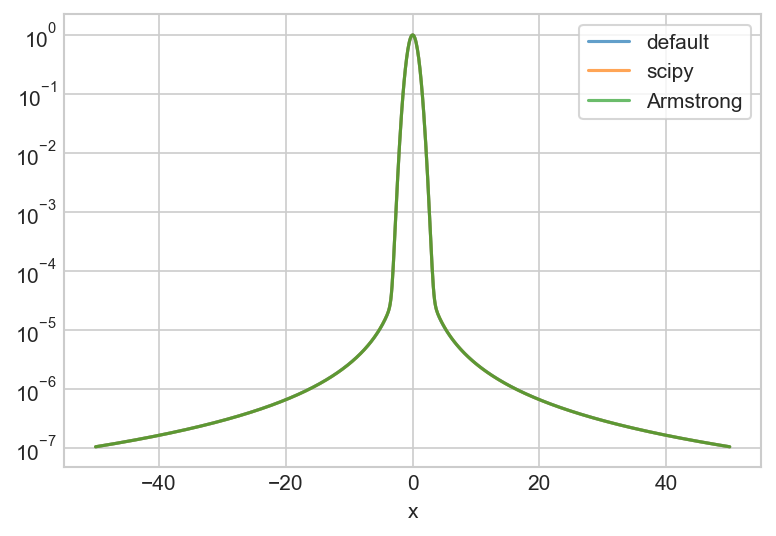

In [4]:
xx = np.linspace(-50,50,1000)

Voigt_type = ['default', 'scipy', 'Armstrong']

for vtype in Voigt_type:
    sigma = lya_cross_section(T=1e4*u.K, Voigt_type=vtype)
    voigt = sigma.Voigt(xx)
    plt.plot(xx, voigt, label=vtype, alpha=0.7)

plt.legend(frameon=True)
# plt.xscale('symlog')
plt.yscale('log')
plt.xlabel('x')

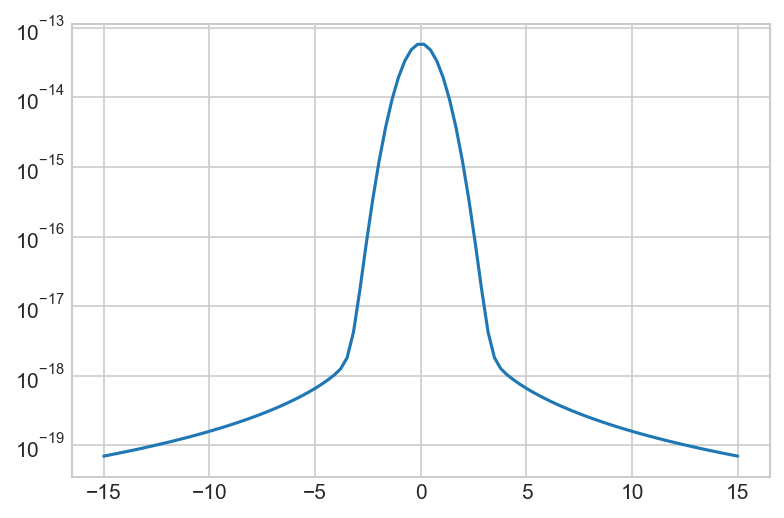

In [5]:
sigma = lya_cross_section(T=1e4 * u.K)
xx = np.linspace(-15,15,100)
y = sigma.Lya_crosssec_x(xx)
plt.plot(xx,y)
plt.yscale('log')

# Optical depth

In [6]:
def n_H(z, X_p=0.75):
    """Mean IGM hydrogen number density"""
    return (X_p * Planck15.Ob0 * Planck15.critical_density0 * (1+z)**3. / const.m_p).to(u.cm**(-3.))

def dt_dz(z):
    return 1. / ((1. + z) * Planck15.H(z))

def wave_to_DV(wave):
    return ((wave - wave_Lya)*const.c/wave_Lya).to(u.km/u.s)

def DV_to_wave(DV):
    return wave_Lya + (DV/const.c * wave_Lya).to(u.Angstrom)

In [7]:
def optical_depth(wave_em, T, z_min, z_max, z_s=7.,
                  C_HII=1., xHI=1e-8, nint = 100, 
                  min_log_x=-1, integral_type='trapz', Voigt_type='default',
                  plot=False):
    """
    Lya optical depth as a function of wavelength 
    using definition of optical depth and Lya cross-section

    assuming uniform nHI
    """
    crosssec = lya_cross_section(T, Voigt_type=Voigt_type)   
    
    # Redshift array
    ztab_ends = np.array([z_min, z_max])
    
    # Observed wavelength
    wave_obs = wave_em * (1. + z_s)
        
    # Range of redshifted wavelength and x
    wave_z_ends = wave_obs[:,None]/(1+ztab_ends)
    x_z_ends    = crosssec.Lya_wave_to_x(wave_z_ends).value

    tau = np.zeros(len(wave_obs))
    for ww, w_obs in enumerate(wave_obs):      

        # Make xtab 
        if (x_z_ends[ww] < 0).all():
            xtab = -np.logspace(np.log10(-x_z_ends[ww].min()),np.log10(-x_z_ends[ww].max()),nint)
            xtab = np.sort(xtab)
        elif (x_z_ends[ww] > 0).all():
            xtab = np.logspace(np.log10(x_z_ends[ww].min()),np.log10(x_z_ends[ww].max()),nint)
            xtab = np.sort(xtab)
        else:       
            xtab_neg = -np.logspace(min_log_x, np.log10(-x_z_ends[ww].min()),nint)
            xtab_pos = np.logspace(min_log_x,np.log10(x_z_ends[ww].max()),nint)
            xtab     = np.sort(np.concatenate((xtab_neg, xtab_pos)))
        
        # Get wave_redshift
        wave_redshift = crosssec.Lya_x_to_wave(xtab)

        # Get z tab
        ztab = w_obs/wave_redshift - 1.
            
        # Cross-section
        lya_cross = crosssec.Lya_crosssec_x(xtab)
                           
        # Calculate optical depth
        prefac = (const.c * dt_dz(ztab) * xHI * C_HII * n_H(ztab)).to(1./u.cm**2.)
        dtau   = prefac * lya_cross

        if plot:
            plt.scatter(ztab, dtau, s=1)
#             plt.xscale('log')
            plt.yscale('log')
            plt.xlim(z_s - 0.1, z_s)


        if integral_type == 'trapz':
            tau[ww] = np.trapz(dtau, ztab)
        elif integral_type == 'simps':
            tau[ww] = simps(dtau, ztab)

    return tau

# Optical depth as a function of n_HI

In [8]:
def plot_optdepth(vlim):
    fig, ax_DV = plt.subplots(1,1)
    ax_wave = ax_DV.twiny()
    
    ax_DV.set_xlim(-vlim, vlim)
    ax_wave.set_xlim(DV_to_wave(np.array(ax_DV.get_xlim())*u.km/u.s).value)

    ax_wave.set_ylabel(r'Ly$\alpha$ transmission')
    ax_wave.set_xlabel(r'Wavelength [$\mathrm{A}$]')
    ax_DV.set_xlabel('Velocity offset [km/s]')

    ax_wave.grid(None)
    ax_wave.axhline(0.8, alpha = 0.5, c = 'k', ls='dashed')
    plt.tight_layout()
    
    return ax_wave, ax_DV

## Max's Fig A1

z=7, T=1eK

0.0
1.0398371415214071e-06
1.0398371415214073e-05
0.00010398371415214073
0.010398371415214071


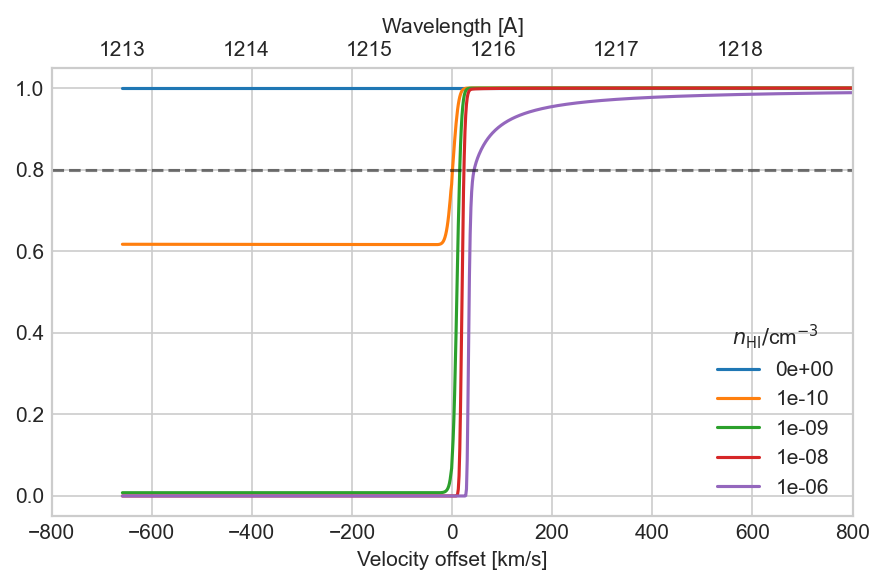

In [9]:
# Integration limits
z_s   = 7.
z_min = 6.
z_max = z_s

T = 1e4 * u.K

## Wavelength grid
wave_em = np.linspace(1213, 1219., 1000) * u.Angstrom
DV_tab  = wave_to_DV(wave_em)
  
ax_wave, ax_DV = plot_optdepth(vlim=800)

nHI_tab = np.array([0., 1e-10, 1e-9, 1e-8, 1e-6])/u.cm**3.

for nHI in nHI_tab:
    
    xHI = nHI / n_H(z_s)
    print(xHI)

    tau = optical_depth(wave_em, T, z_min=z_min, z_max=z_max, z_s=z_s,
                        C_HII=1., xHI=xHI, nint=1000)
    
    ax_wave.plot(wave_em, np.exp(-tau), lw=0)
    ax_DV.plot(DV_tab, np.exp(-tau), label=f'{nHI.value:.0e}')

ax_DV.legend(title='$n_\mathrm{HI}/$cm$^{-3}$', loc='lower right')

1.0
0.554182263810565
0.0027323145717677174
2.3214232796898764e-26
0.0
0.0
0.0


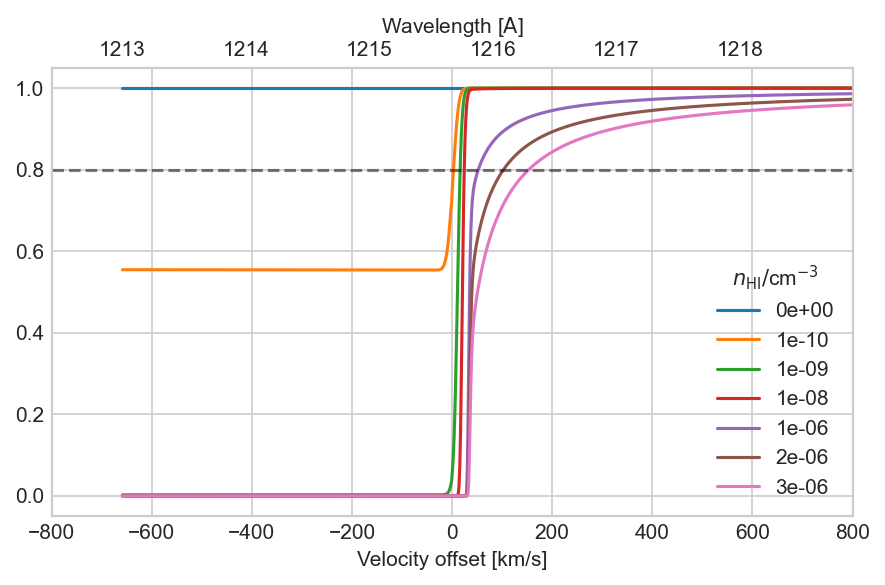

In [10]:
# Integration limits
z_s   = 5.99
z_min = 5.
z_max = z_s + 1e-2

z_s   = 6.
z_min = 5.
z_max = z_s

T = 1e4 * u.K

## Wavelength grid
wave_em = np.linspace(1213, 1219., 1000) * u.Angstrom
DV_tab  = wave_to_DV(wave_em)

# Velocity plot limits
vlim = 800
  
ax_wave, ax_DV = plot_optdepth(vlim)

nHI_tab = np.array([0., 1e-10, 1e-9, 1e-8, 1e-6, 2e-6, 3e-6])/u.cm**3.

for nHI in nHI_tab:
    
    xHI = nHI / n_H(z_s)

    tau = optical_depth(wave_em, T, z_min=z_min, z_max=z_max, z_s=z_s,
                        C_HII=1., xHI=xHI, nint = 1000)
    
    ax_wave.plot(wave_em, np.exp(-tau), lw=0)
    ax_DV.plot(DV_tab, np.exp(-tau), label=f'{nHI.value:.0e}')
    print(np.mean(np.exp(-tau[DV_tab.value<-100])))

ax_DV.legend(title='$n_\mathrm{HI}/$cm$^{-3}$', loc='lower right')

# Check Voigt profile method

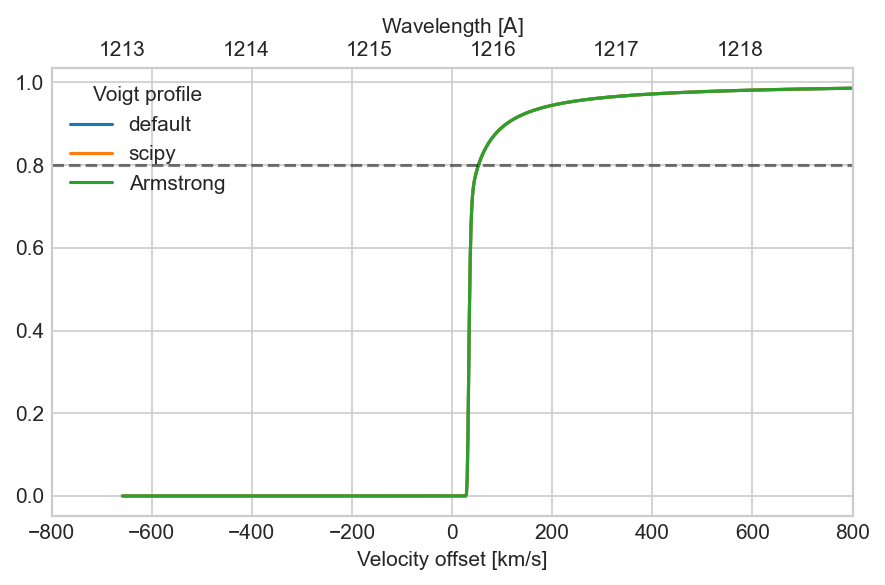

In [11]:
# Integration limits
z_s   = 6.
z_min = 5.
z_max = z_s
T = 1e4 * u.K

## Wavelength grid
wave_em = np.linspace(1213, 1219., 1000) * u.Angstrom
DV_tab  = wave_to_DV(wave_em)

# Velocity plot limits
vlim = 800
ax_wave, ax_DV = plot_optdepth(vlim)

nHI = 1e-6/u.cm**3.
xHI = nHI / n_H(z_s)

Voigt_type = ['default', 'scipy', 'Armstrong']

for vtype in Voigt_type:
    
    tau = optical_depth(wave_em, T, z_min=z_min, z_max=z_max, z_s=z_s,
                        C_HII=1., xHI=xHI, nint = 100,
                        Voigt_type=vtype)
    
    ax_wave.plot(wave_em, np.exp(-tau), lw=0)
    ax_DV.plot(DV_tab, np.exp(-tau), label=vtype)

ax_DV.legend(title='Voigt profile')

# Check tau convergence for Max

How far do you need to integrate to get the right tau?

9.36055558600462
[0. 6.] Mpc
[ 5. 11.] Mpc
18.72111117200924
[ 0.  6. 12. 18.] Mpc
[ 5. 11. 17. 23.] Mpc
28.08166675801386
[ 0.  6. 12. 18. 24.] Mpc
[ 5. 11. 17. 23. 29.] Mpc
37.44222234401848
[ 0.  6. 12. 18. 24. 30. 36.] Mpc
[ 5. 11. 17. 23. 29. 35. 41.] Mpc


/Users/cmason/opt/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/cmason/opt/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/cmason/opt/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/cmason/opt/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0, 0.5, 'Transmission, $e^{-\\tau}$')

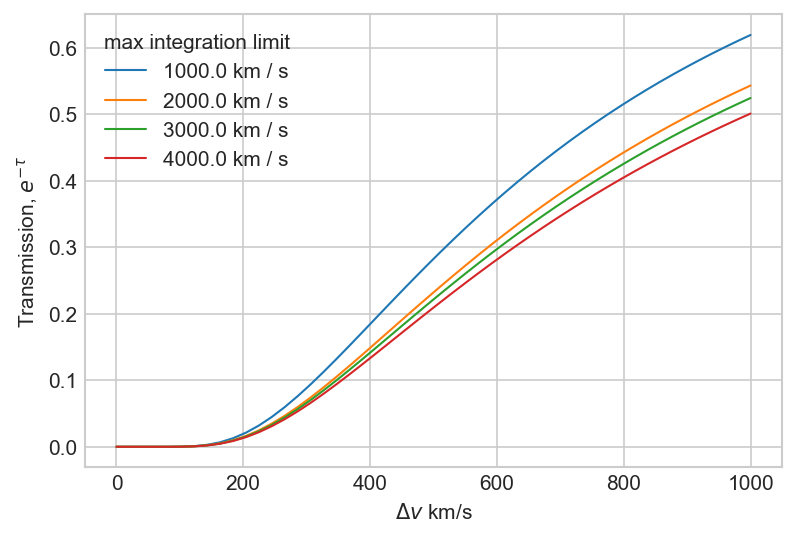

In [10]:
def tau_GP(z):
    return 7e5 * ((1+z)/10)**1.5

def tau_D(DV, Rb, Re, z=7.):
    a_v = 4.7019e-4
    xb = x(Rb, DV, z)
    xe = x(Re, DV, z)
    return tau_GP(z)*a_v/np.pi * np.sum(1./xe - 1/xb, axis=1)

def x(R, DV, z=7.):
    vth = (1./np.sqrt(const.m_p/2./const.k_B/1e4/u.K)).to(u.km/u.s)
    return (-(DV + Planck15.H(z)*R/(1+z))/vth).value

DV = np.linspace(0, 1000)*u.km/u.s
z = 7.
max_Rb_prop_tab = np.arange(100, 2000, 500) * u.km/u.s / Planck15.H(z) #np.arange(0.5, 3., 0.5)
max_Rb_kms_tab = np.arange(1000, 5000, 1000) * u.km/u.s #np.arange(0.5, 3., 0.5)

bubble_width = 5*u.Mpc
bubble_spacing = 6
for max_Rb_kms in max_Rb_kms_tab:
    print((max_Rb_kms*(1+z)/Planck15.H(z)).value)
    
    Rb = np.arange(0., (max_Rb_kms*(1+z)/Planck15.H(z)).value, bubble_spacing)*u.Mpc
    print(Rb)
    Re = Rb+bubble_width
    print(Re)

#     plt.plot(DV, np.exp(-tau_D(DV=DV[:,None], Rb=Rb, Re=Re)), lw=1, label=f'{max_Rb_prop*u.Mpc*Planck15.H(z):.1f} pMpc')
    plt.plot(DV, np.exp(-tau_D(DV=DV[:,None], Rb=Rb, Re=Re)), lw=1, label=f'{max_Rb_kms:.1f}')

    
plt.legend(title='max integration limit')
plt.xlabel('$\Delta v$ km/s')
plt.ylabel(r'Transmission, $e^{-\tau}$')

/Users/cmason/opt/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0, 0.5, 'Transmission, $e^{-\\tau}$')

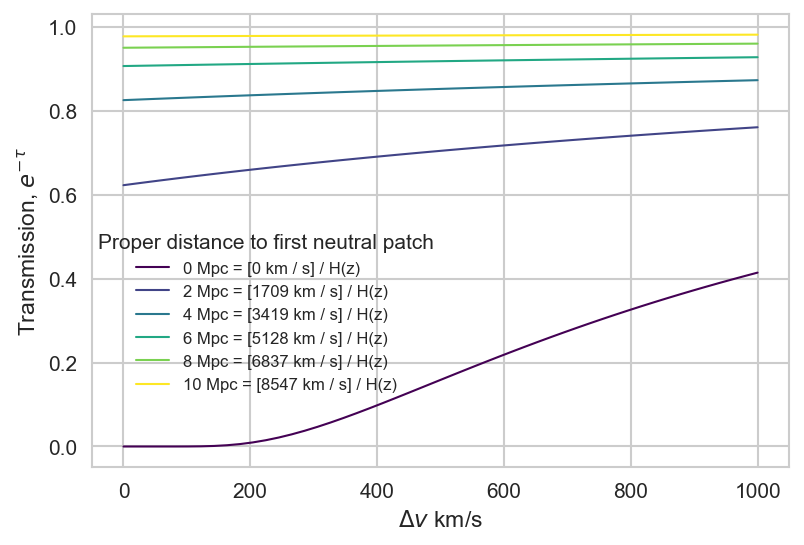

In [59]:
DV = np.linspace(0, 1000)*u.km/u.s
z = 7.

Rb_proper_tab = np.arange(0,12,2) * u.Mpc
colors = plt.cm.viridis(np.linspace(0,1,len(Rb_proper_tab)))

plt.figure(figsize=(6,4))

for i, Rb_proper in enumerate(Rb_proper_tab):
    Rb_comov = Rb_proper * (1 + z)
    plt.plot(DV, np.exp(-tau_D(DV=DV[:,None], Rb=Rb_comov, Re=100*u.Mpc)), 
             c=colors[i], lw=1, label=f'{Rb_proper:.0f} = [{Rb_proper*Planck15.H(z):.0f}] / H(z)')

plt.legend(title='Proper distance to first neutral patch', framealpha=1, fontsize=8, loc=(0.,0.15))
# plt.grid(b=None)
plt.xlabel('$\Delta v$ km/s')
plt.ylabel(r'Transmission, $e^{-\tau}$')

# Integration tests

$$ \tau_\alpha(\lambda_\mathrm{obs}) = \int_{z_\mathrm{min}}^{z_\mathrm{max}} \, \mathrm{d} z \; c \frac{\mathrm{d} t}{\mathrm{d} z} \, n_\mathrm{HI}(z)  \, \sigma_\alpha\left(\frac{\lambda_\mathrm{obs}}{1 + z}, T \right) $$

Usually, $z_{min} = 0$, $z_{max} = z_s$

## Check resolution of grid

Change resolution of x grid in `optical_depth()`

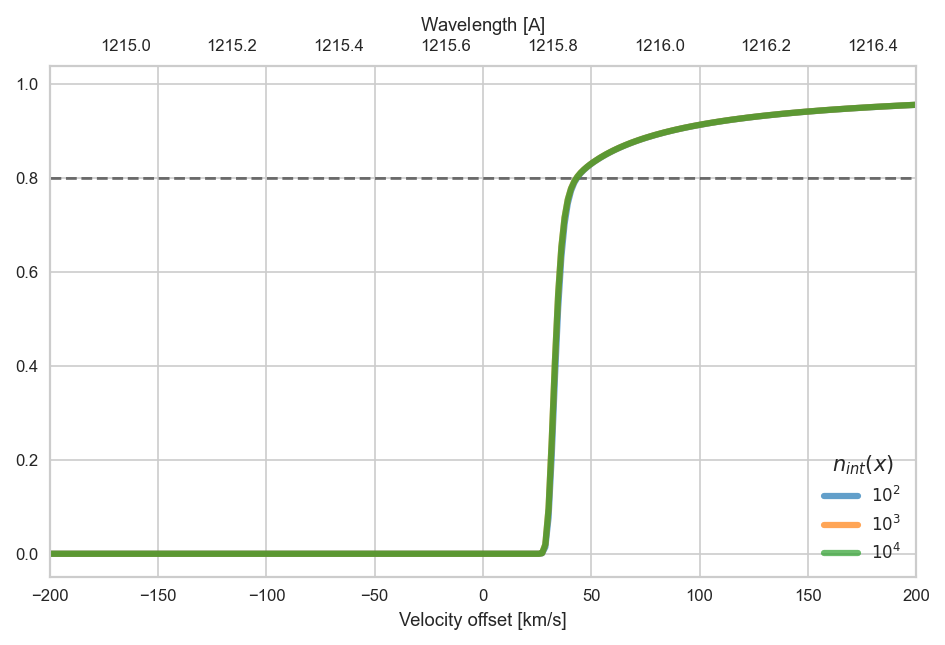

In [20]:
### Change x grid resolution

# Integration limits
z_s   = 7.
z_min = 0.
z_max = z_s

wave_em = np.linspace(1213, 1219., 1000) * u.Angstrom
DV_tab  = wave_to_DV(wave_em)
vlim    = 200
   
ax_wave, ax_DV = plot_optdepth(vlim)

for n in [100, 1000, 10000]:
    tau = optical_depth(wave_em, T=1e4*u.K, z_min=z_min, z_max=z_s, z_s=z_s,
                    C_HII=1., xHI=1e-2, nint = n)

    ax_wave.plot(wave_em, np.exp(-tau), lw=3, alpha=0.7, label=f'$10^{np.log10(n):.0f}$')
    ax_DV.plot(DV_tab, np.exp(-tau), lw=0)

ax_wave.legend(title='$n_{int}(x)$', loc='lower right')

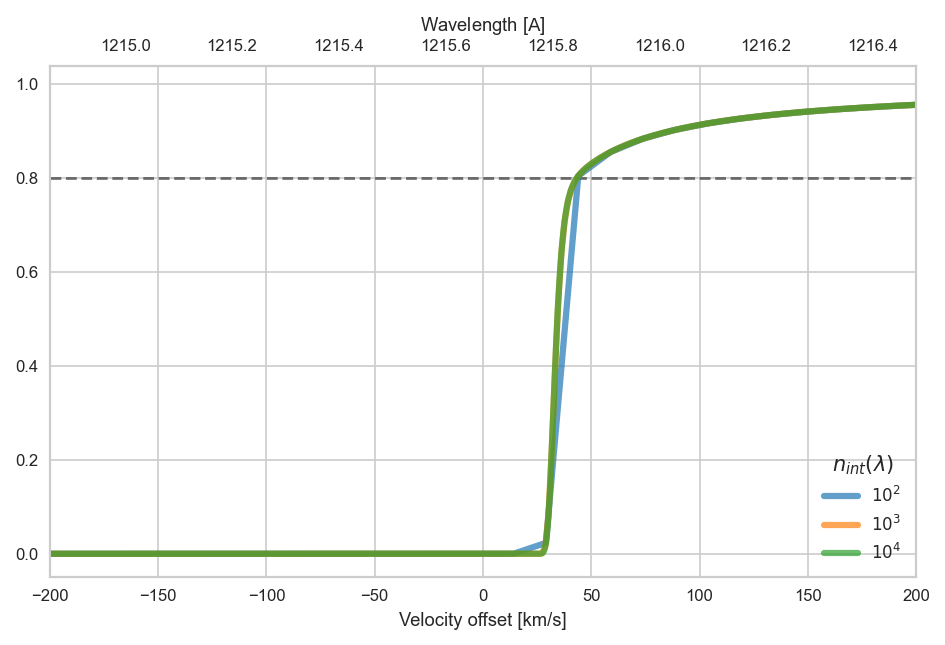

In [21]:
### Change wavelegnth grid resolution

# Integration limits
z_s   = 7.
z_min = 6.
z_max = z_s

vlim    = 200
   
ax_wave, ax_DV = plot_optdepth(vlim)

for n in [100, 1000, 10000]:
    wave_em = np.linspace(1213, 1219., n) * u.Angstrom
    DV_tab  = wave_to_DV(wave_em)

    tau = optical_depth(wave_em, T=1e4*u.K, z_min=z_min, z_max=z_s, z_s=z_s,
                    C_HII=1., xHI=1e-2, nint=100)

    ax_wave.plot(wave_em, np.exp(-tau), lw=3, alpha=0.7, label=f'$10^{np.log10(n):.0f}$')
    ax_DV.plot(DV_tab, np.exp(-tau), lw=0)

ax_wave.legend(title='$n_{int}(\lambda)$', loc='lower right')

## Integration limits (z_min)

Do we need to integrate all the way back to z=0?

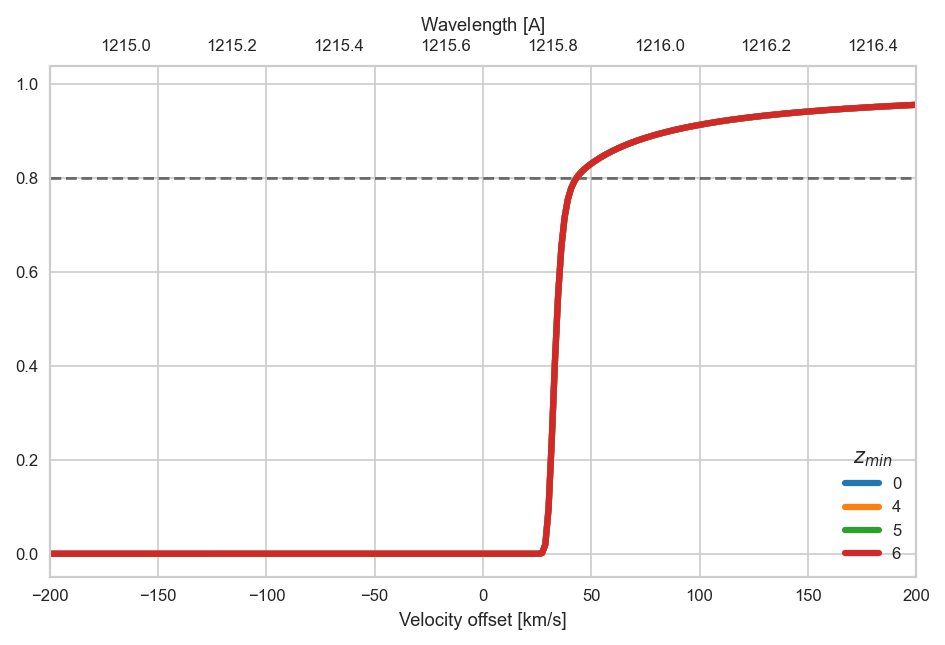

In [22]:
# Integration limits
z_s   = 7.
z_max = z_s

wave_em = np.linspace(1213, 1219., 1000) * u.Angstrom
DV_tab  = wave_to_DV(wave_em)
vlim    = 200
   
ax_wave, ax_DV = plot_optdepth(vlim)

for z_min in [0., 4., 5., 6.]:
    tau = optical_depth(wave_em, T=1e4*u.K, z_min=z_min, z_max=z_s, z_s=z_s,
                      C_HII=1., xHI=1e-2, nint = 1000)

    ax_wave.plot(wave_em, np.exp(-tau), lw=3, label=f'{z_min:.0f}')
    ax_DV.plot(DV_tab, np.exp(-tau), lw=0)

ax_wave.legend(title='$z_{min}$', loc='lower right')

## Integration limits (z_max)

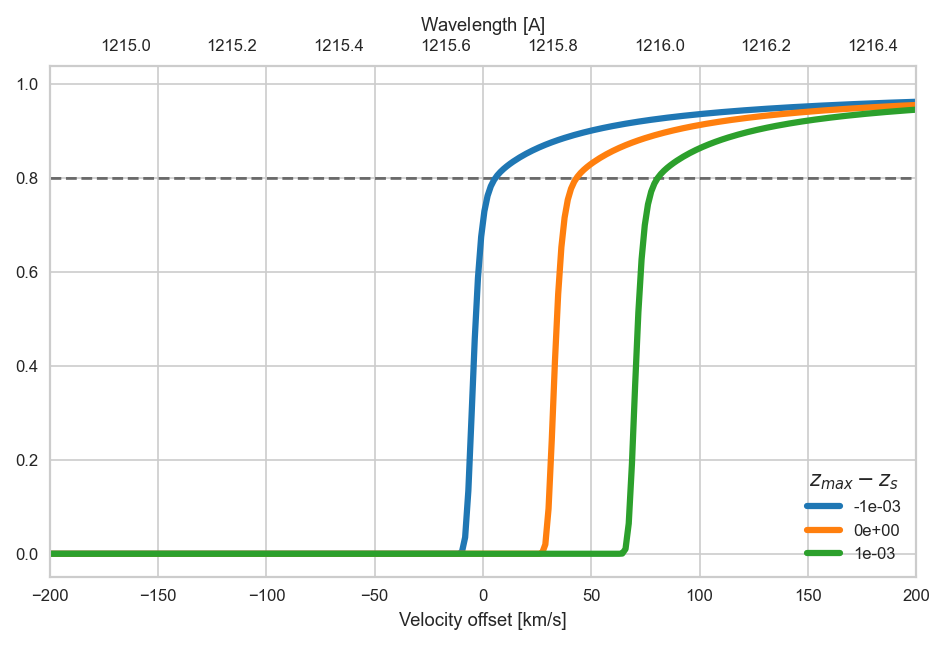

In [23]:
# Integration limits
z_s   = 7.
z_min = 6.

wave_em = np.linspace(1213, 1219., 1000) * u.Angstrom
DV_tab  = wave_to_DV(wave_em)
vlim    = 200
   
ax_wave, ax_DV = plot_optdepth(vlim)

for d_z_max in [-1e-3, 0, 1e-3]:
    tau = optical_depth(wave_em, T=1e4*u.K, z_min=z_min, z_max=z_s+d_z_max, z_s=z_s,
                      C_HII=1., xHI=1e-2, nint = 1000)

    ax_wave.plot(wave_em, np.exp(-tau), lw=3, label=f'{d_z_max:.0e}')

    ax_DV.plot(DV_tab, np.exp(-tau), lw=0)

ax_wave.legend(title='$z_{max} - z_s$', loc='lower right')

## Integration method

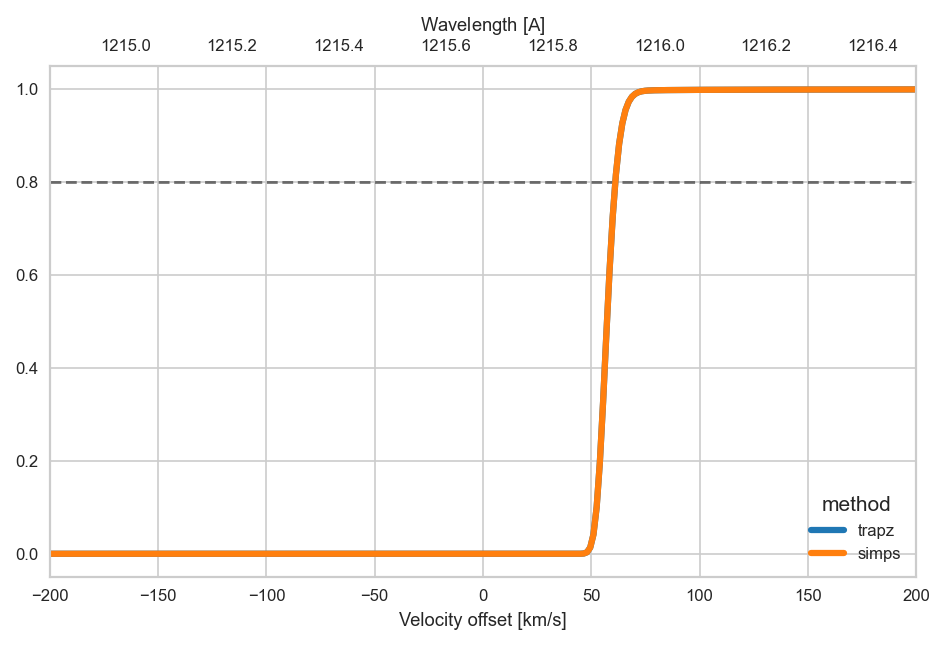

In [24]:
# Integration limits
z_s   = 7.
z_min = 6.

wave_em = np.linspace(1213, 1219., 1000) * u.Angstrom
DV_tab  = wave_to_DV(wave_em)
vlim    = 200
   
ax_wave, ax_DV = plot_optdepth(vlim)

for int_type in ['trapz','simps']:
    tau = optical_depth(wave_em, T=1e4*u.K, z_min=z_min, z_max=z_s+d_z_max, z_s=z_s,
                      C_HII=1., xHI=1e-4, nint = 1000, integral_type=int_type)

    ax_wave.plot(wave_em, np.exp(-tau), lw=3, label=int_type)
    ax_DV.plot(DV_tab, np.exp(-tau), lw=0)

ax_wave.legend(title='method', loc='lower right')

## Minimum x value

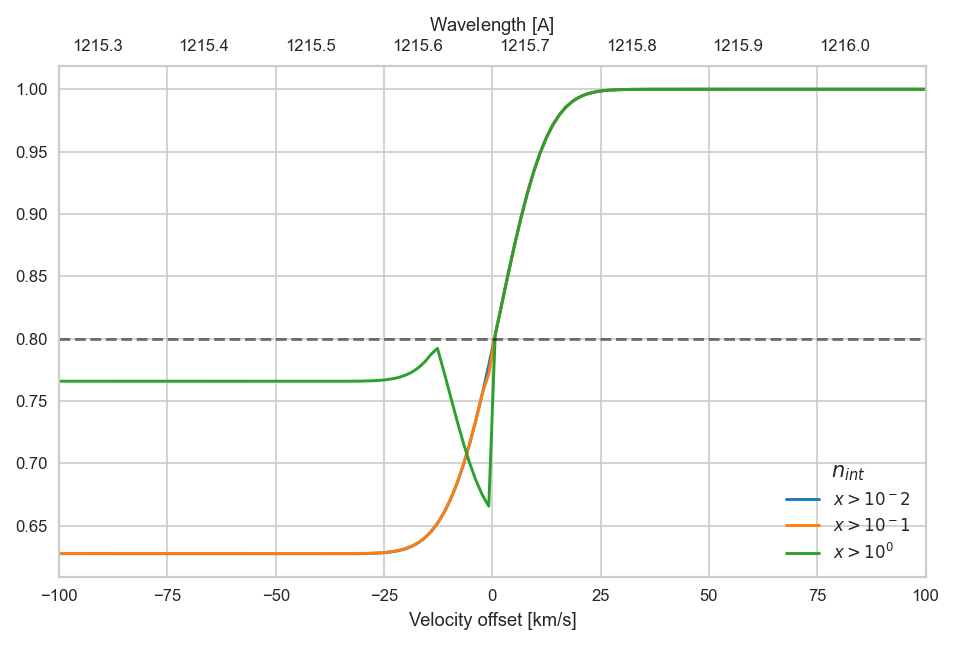

In [25]:
# Integration limits
z_s   = 7.
z_min = 6.
z_max = z_s

wave_em = np.linspace(1213, 1219., 1000) * u.Angstrom

# Make DV table
DV_tab = wave_to_DV(wave_em)
vlim = 100
   
ax_wave, ax_DV = plot_optdepth(vlim)

for min_log_x in [-2, -1, 0]:
    tau = optical_depth(wave_em, T=1e4*u.K, z_min=z_min, z_max=z_max, z_s=z_s,
                      C_HII=1., xHI=1e-6, nint = 1000, min_log_x=min_log_x)

    ax_wave.plot(wave_em, np.exp(-tau), lw=0)
    ax_DV.plot(DV_tab, np.exp(-tau), label=f'$x > 10^{min_log_x:.0f}$')

ax_DV.legend(title='$n_{int}$', loc='lower right')